# AlphaZero supervised learning
_Will Kaufman, January 2021_

This is simply to generate training data and do supervised learning so I can test different neural network designs, and to make sure it can actually learn from the data.

In [1]:
import qutip as qt
import numpy as np
import sys
import os
import multiprocessing as mp
import importlib
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('..'))
import pulse_sequences as ps
import alpha_zero as az

In [133]:
# importlib.reload(az)
# importlib.reload(ps)

<module 'pulse_sequences' from '/Users/willkaufman/Projects/rl_pulse/rl_pulse/pulse_sequences.py'>

## Define hyperparameters

In [4]:
num_cores = 2  # 32
num_collect_initial = 2  # 5000

max_sequence_length = 48
batch_size = 2048
num_epochs = 10
num_batches = 46

## Define the spin system

In [5]:
delay = 1e-2  # time is relative to chemical shift strength
pulse_width = 1e-3
N = 3  # number of spins
ensemble_size = 5

In [6]:
Utarget = qt.tensor([qt.identity(2)] * N)

In [6]:
rb = az.ReplayBuffer(int(1e5))

## Get data and save to file

In [7]:
def collect_data_no_net(x):
#     print(f'collecting data without network ({x})')
    config = az.Config()
    ps_config = ps.PulseSequenceConfig(N=N, ensemble_size=ensemble_size,
                                       max_sequence_length=max_sequence_length,
                                       Utarget=Utarget,
                                       pulse_width=pulse_width, delay=delay)
    return az.make_sequence(config, ps_config, network=None, rng=ps_config.rng)

In [8]:
with mp.Pool(num_cores) as pool:
    output = pool.map(collect_data_no_net, range(num_collect_initial))
for stat in output:
    az.add_stats_to_buffer(stat, rb)

In [13]:
states, probabilities, values = zip(*rb.buffer)

In [19]:
packed_states = az.pad_and_pack(states)
probabilities = torch.cat(probabilities).view(len(rb), -1)
values = torch.cat(values).view(len(rb), -1)

In [30]:
torch.save(packed_states, 'states.pt')
torch.save(probabilities, 'probabilities.pt')
torch.save(values, 'values.pt')

In [31]:
# len(rb)

## Supervised learning from data

In [ ]:
policy = az.Policy()
value = az.Value()

In [7]:
packed_states = torch.load('../../data/2021-01/20210116-110000/states.pt')

In [8]:
padded_states = torch.nn.utils.rnn.pad_packed_sequence(packed_states, batch_first=True)

In [9]:
probabilities = torch.load('../../data/2021-01/20210116-110000/probabilities.pt')
values = torch.load('../../data/2021-01/20210116-110000/values.pt')

In [10]:
class PulseSequenceDataset(Dataset):
    def __init__(self, padded_states, probabilities, values):
        super().__init__()
        self.padded_states = padded_states
        self.probabilities = probabilities
        self.values = values
    
    def __getitem__(self, idx):
        return (self.padded_states[0][idx, ...],
                self.padded_states[1][idx, ...],
                self.probabilities[idx, ...],
                self.values[idx, ...])
    
    def __len__(self):
        return self.values.size(0)

In [11]:
dataset = PulseSequenceDataset(padded_states, probabilities, values)

In [12]:
def collate_fn(data):
    states, lengths, probs, vals = zip(*data)
    states = torch.stack(states)
    lengths = torch.stack(lengths)
    packed_states = torch.nn.utils.rnn.pack_padded_sequence(states, lengths,
                                                            batch_first=True,
                                                            enforce_sorted=False)
    probs = torch.stack(probs)
    vals = torch.stack(vals)
    return packed_states, probs, vals

In [13]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [14]:
sample = next(iter(loader))

In [17]:
policy_outputs, _ = policy(sample[0])

In [174]:
vals = values.numpy()

(array([ 1308.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0., 28320., 34896.,
         3552.,     0.,    48.,   528.,   480.,   624.,   720.,  1248.,
         1536.,  1728.,  2256.,  1680.,  2112.,  1104.,  2160.,  1632.,
         1296.,  1776.,  1152.,  1104.,   528.,   624.,   432.,   672.,
          480.,   624.,   384.,   480.,   192.,    96.,     0.,    48.,
           48.,    96.]),
 array([-1.        , -0.92981917, -0.85963833, -0.78945744, -0.7192766 ,
        -0.6490958 , -0.57891494, -0.5087341 , -0.43855324, -0.36837238,
        -0.29819155, -0.2280107 , -0.15782985, -0.08764901, -0.01746817,
         0.05271268,  0.12289353,  0.19307438,  0.2632552 ,  0.33343607,
         0.4036169 ,  0.47379774,  0.5439786 ,  0.61415946,  0.6843403 ,
         0.75452113,  0.82470196,  0.8948828 ,  0.9650637 ,  1.0352445 ,
         1.1054254 ,  1.1756063 ,  1.245787  ,  1.3159679 ,  1.3861487 ,
         1.4563296 ,  1.5265105

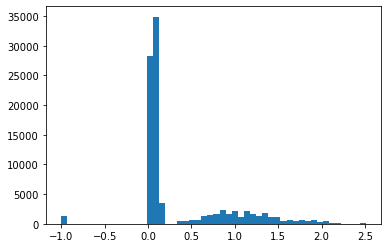

In [18]:
plt.hist(vals, bins=50)

In [62]:
np.sum(vals > .25) / vals.size

0.2906089783668876

In [175]:
print(np.mean(vals))
print(np.var(vals))

0.36310405
0.31326103


In [49]:
print(np.mean(vals[vals > .2]))
print(np.var(vals[vals > .2]))

1.1366603
0.18059035


## Quantify entropy in MCTS probabilities

In [50]:
entropies = -torch.nansum(probabilities * torch.log(probabilities), 1)
entropies = entropies.numpy()

In [56]:
entropies.size

95964

In [58]:
np.sum(entropies <= np.log(4)) / entropies.size

0.4354445417031387

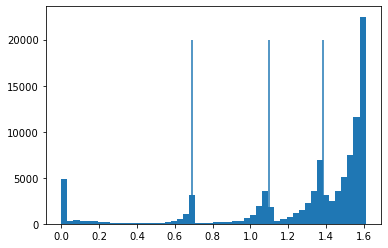

In [51]:
plt.hist(entropies, bins=50)
plt.vlines(x=np.log(2), ymin=0, ymax=20000, label='2')
plt.vlines(x=np.log(3), ymin=0, ymax=20000, label='3')
plt.vlines(x=np.log(4), ymin=0, ymax=20000, label='4')

## Optimize networks with dataset

In [348]:
class Policy(nn.Module):
    def __init__(self, input_size=6, lstm_size=64, output_size=5):
        super(Policy, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_size,
                            num_layers=1,
                            batch_first=True)
        self.fc1 = nn.Linear(lstm_size, output_size)

    def forward(self, x, h0=None, c0=None):
        """Calculates the policy from state x

        Args:
            x: The state of the pulse sequence. Either a tensor with
                shape B*T*(num_actions + 1), or a packed sequence of states.
        """
        if h0 is None or c0 is None:
            x, (h, c) = self.lstm(x)
        else:
            x, (h, c) = self.lstm(x, (h0, c0))
        if type(x) is torch.Tensor:
            x = x[:, -1, :]
        elif type(x) is nn.utils.rnn.PackedSequence:
            # x is PackedSequence, need to get last timestep from each
            x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
            idx = (
                lengths.long() - 1
            ).view(
                -1, 1
            ).expand(
                len(lengths), x.size(2)
            ).unsqueeze(1)
            x = x.gather(1, idx).squeeze(1)
        x = F.softmax(self.fc1(x), dim=1)
        return x, (h, c)

In [349]:
class Value(nn.Module):
    def __init__(self, input_size=6, lstm_size=64):
        super(Value, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_size,
                            num_layers=1,
                            batch_first=True)
        self.fc1 = nn.Linear(lstm_size, 1)

    def forward(self, x, h0=None, c0=None):
        """Calculates the value from state x

        Args:
            x: The state of the pulse sequence. Either a tensor with
                shape B*T*(num_actions + 1), or a packed sequence of states.
        """
        if h0 is None or c0 is None:
            x, (h, c) = self.lstm(x)
        else:
            x, (h, c) = self.lstm(x, (h0, c0))
        if type(x) is torch.Tensor:
            x = x[:, -1, :]
        elif type(x) is nn.utils.rnn.PackedSequence:
            # x is PackedSequence, need to get last timestep from each
            x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
            idx = (
                lengths.long() - 1
            ).view(
                -1, 1
            ).expand(
                len(lengths), x.size(2)
            ).unsqueeze(1)
            x = x.gather(1, idx).squeeze(1)
        x = self.fc1(x)
        return x, (h, c)

In [378]:
policy = Policy(lstm_size=32)
value = Value(lstm_size=32)

In [379]:
policy_optimizer = optim.Adam(policy.parameters())
value_optimizer = optim.Adam(value.parameters())

TODO keep trying out different learning rates, see if that' enough to start learning
then move on to different NN architectures, continue from there.......

In [172]:
# old_policy_loss = torch.as_tensor(100)
# old_value_loss = torch.as_tensor(100)
# for epoch in range(num_epochs):
#     batch_num = 0
#     for packed_states, probs, vals in iter(loader):
#         print(f'on epoch {epoch}, batch {batch_num}', end='\t')
#         policy_optimizer.zero_grad()
#         value_optimizer.zero_grad()
#         policy_output, _ = policy(packed_states)
#         value_outputs, _ = value(packed_states)
#         policy_loss = -1 / batch_size * torch.sum(sample[1] * torch.log(policy_output))
#         value_loss = F.mse_loss(value_outputs, sample[2])
#         policy_loss.backward()
#         policy_optimizer.step()
#         value_loss.backward()
#         value_optimizer.step()
#         print(f'policy loss: {policy_loss}, value loss: {value_loss}')
#         if old_policy_loss / policy_loss < 1.01:
#             print(f'policy loss is less than 1% better ({old_policy_loss / policy_loss})')
#         if old_value_loss / value_loss < 1.01:
#             print(f'value loss is less than 1% better ({old_value_loss / value_loss})')
#         old_policy_loss = policy_loss
#         old_value_loss = value_loss
#         batch_num += 1

Some commentary... Seems like the training process flatlines with cross entropy loss around 1.6 and MSE loss around 0.3. Things to play around with...

- changing network architecture
- changing learning rate etc.

LSTM hidden size 64 stagnated at policy loss: 1.606, value loss: 0.31

### Network class: combining policy and value networks

TODO add more residual layers (maybe??)

In [7]:
class Network(nn.Module):
    """A network with policy and value heads
    """
    def __init__(self,
                 input_size=6,
                 rnn_size=64,
                 fc_size=32,
                 policy_output_size=5,
                 value_output_size=1):
        super(Network, self).__init__()
        # define layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=rnn_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
        )
        self.batchnorm1 = nn.BatchNorm1d(rnn_size)
        self.fc1 = nn.Linear(rnn_size, fc_size)
        self.batchnorm2 = nn.BatchNorm1d(fc_size)
        self.fc2 = nn.Linear(fc_size, fc_size)
        self.batchnorm3 = nn.BatchNorm1d(fc_size)
        self.policy = nn.Linear(fc_size, policy_output_size)
        self.value = nn.Linear(fc_size, value_output_size)

    def forward(self, x, h_0=None):
        """Calculates the policy and value from state x

        Args:
            x: The state of the pulse sequence. Either a tensor with
                shape B*T*(num_actions + 1), or a packed sequence of states.
        """
        # RNN layer
        if h_0 is None:
            x, h = self.gru(x)
        else:
            x, h = self.gru(x, h_0)
        if type(x) is torch.Tensor:
            x = x[:, -1, :]
        elif type(x) is nn.utils.rnn.PackedSequence:
            # x is PackedSequence, need to get last timestep from each
            x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
            idx = (
                lengths.long() - 1
            ).view(-1, 1).expand(
                len(lengths), x.size(2)
            ).unsqueeze(1)
            x = x.gather(1, idx).squeeze(1)
        x = F.relu(self.batchnorm1(x))
        # hidden residual layers
        x = F.relu(self.batchnorm2(self.fc1(x)))
        x = F.relu(self.batchnorm3(self.fc2(x)) + x)  # skip connection from '+ x'
        policy = F.softmax(self.policy(x), dim=1)
        value = self.value(x)
        return policy, value, h

In [8]:
net = Network()
# p, v, h = net(sample[0])

In [9]:
net_optimizer = optim.Adam(net.parameters())

Seems to take about 40 minibatches of size 2048 to get to stable learning. The MSE is the same as the variance of the data though, so it's not picking up on much information...

In [176]:
for epoch in range(num_epochs):
    batch_num = 0
    for packed_states, probs, vals in iter(loader):
        print(f'on epoch {epoch}, batch {batch_num}', end='\t')
        net_optimizer.zero_grad()
        p, v, _ = net(packed_states)
        policy_loss = -1 / batch_size * torch.sum(probs * torch.log(p))
        value_loss = F.mse_loss(v, vals)
        loss = policy_loss + value_loss
        loss.backward()
        net_optimizer.step()
        print(f'policy loss: {policy_loss}, value loss: {value_loss}')
        batch_num += 1

## Shared memory

I want the replay buffer and the neural network parameters to be shared between processes. I think pytorch's `torch.multiprocessing` module ([see here](https://pytorch.org/docs/stable/multiprocessing.html)) will be the best option. But there's very little documentation, they just point to the native `multiprocessing` module. Helpful...

Also `multiprocessing` has a [shared memory module](https://docs.python.org/3/library/multiprocessing.shared_memory.html) that could work. But it looks pretty low-level, won't be super easy to implement.

I'm reading through the `multiprocessing` module docs right now...

Alright, I think what I want to do is to use `Manager()` and write a proxy class for the replay buffer. Then I instantiate a `ReplayBuffer` object with the maanger, and then each process gets a proxy that can read/write to it. See [the official docs](https://docs.python.org/3/library/multiprocessing.html#proxy-objects) and [this StackOverflow question](https://stackoverflow.com/questions/3671666/sharing-a-complex-object-between-processes) for help.

Also check out [this pytorch doc](https://pytorch.org/docs/stable/notes/multiprocessing.html) for how to share a model's memory with multiple processes.

# TODO

- [ ] `f` is the MCTS worker process, `g` is the training process, l is the replay buffer and model is the network
- [ ] See how `Value()` works, flesh out replay buffer functionality (write methods for it?)

In [212]:
from multiprocessing import Process, Lock, Queue, Manager

In [13]:
import torch.multiprocessing as mp
from time import sleep

In [22]:
buffer_size = 100

In [28]:
def f(num, buffer, index, model):
    print(f'in f {num}')
    rng = np.random.default_rng()  # to make each process use different random numbers
    state = rng.normal(size=(5, 10, 6))
    state = torch.tensor(state).float()  # converts to float32 tensor
#     print(state)
    sleep(num)
    print('trying to calculate result')
    with torch.no_grad():  # no_grad so no backpropagation information is calculated/stored
        # also don't have to detach tensors then
        output = model(state)
    print('appending...')
#     with index.get_lock():
    buffer[index.value] = output
    index.value += 1
    # TODO wrap around index if

def g(buffer, index, model):
    sleep(1.5)
    print('got to g')
    for i in range(5):
        sleep(1)
        # print(buffer)
        print(index)
        # print(model)


if __name__ == '__main__':
    with mp.Manager() as manager:
        buffer = manager.list([None] * buffer_size)
        index = manager.Value(typecode='i', value=0)
        model = Network()
        model.share_memory()
        q = mp.Process(target=g, args=(buffer, index, model))
        q.start()
        workers = []
        for i in range(4):
            workers.append(mp.Process(target=f, args=(i, buffer, index, model)))
            workers[-1].start()
        q.join()
        for w in workers:
            w.join()
        print(buffer)

## DEBUG

In [16]:
from time import sleep

In [17]:
rng = np.random.default_rng()

In [35]:
def f(num, buffer, index, lock):
    rng = np.random.default_rng()
    sleep(rng.random() * 2)
    print(f'in f {num}')
    with lock:
        if len(buffer) < 10:
            buffer.append(num)
            index.value += 1
        else:
            buffer[index.value] = num
            index.value += 1
        if index.value >= 10:
            index.value = 0

if __name__ == '__main__':
    with mp.Manager() as manager:
        buffer = manager.list()
        index = manager.Value(typecode='i', value=0)
        lock = manager.RLock()
        workers = []
        for i in range(20):
            workers.append(mp.Process(target=f, args=(i, buffer, index, lock)))
            workers[-1].start()
        for w in workers:
            w.join()
        print(buffer)
        print(type(buffer))
        a = list(buffer)

in f 3
in f 5
in f 13
in f 8
in f 0
in f 11in f 4

in f 14
in f 15
in f 19
in f 17
in f 12
in f 9
in f 10
in f 6
in f 7
in f 1
in f 16
in f 18
in f 2
[17, 12, 9, 10, 6, 7, 1, 16, 18, 2]
<class 'multiprocessing.managers.ListProxy'>


## Pull out well-performing pulse sequences

In [237]:
candidate_idx = values.squeeze() > 2

In [241]:
is_full_sequence = padded_states[1] == 48

In [245]:
candidate_sequences = padded_states[0][candidate_idx * is_full_sequence]

In [297]:
values[candidate_idx * is_full_sequence].squeeze()

tensor([2.0507, 2.1880, 2.0568, 2.3259, 2.0891, 2.0475, 2.0465, 2.0025, 2.0391,
        2.4547, 2.0190, 2.0536, 2.0163, 2.4376, 2.1477, 2.0211, 2.0812, 2.0972,
        2.0765, 2.1756, 2.5090, 2.0155, 2.1318])

In [302]:
candidate_sequences.shape

torch.Size([23, 48, 6])

In [130]:
ps_config = ps.PulseSequenceConfig(N=3, ensemble_size=10, max_sequence_length=48, Utarget=Utarget)

In [308]:
candidates = []
for i in range(candidate_sequences.size(0)):
    sequence = list(torch.argmax(candidate_sequences[i,...], dim=1).numpy()[1:] - 1)
    sequence += ps.get_valid_time_suspension_pulses(sequence, num_pulses=5, sequence_length=48)
    fidelity = ps.get_mean_fidelity(sequence, Utarget, ps_config.pulses_ensemble)
    reward = -np.log10(1 - fidelity + 1e-200)
    candidates.append((sequence, reward))

In [318]:
candidates.sort(key=lambda x: -x[1])

In [322]:
for i in range(5):
    print(candidates[i][1])

2.2353464312128435
2.1204414626672023
2.0665367613756347
2.000438338687582
1.9058772164486646


In [134]:
# compare with yxx48 sequence
yxx48_fidelity = ps.get_mean_fidelity(ps.yxx48, Utarget, ps_config.pulses_ensemble)
yxx48_reward = -np.log10(1 - yxx48_fidelity + 1e-200)

In [135]:
yxx48_reward

3.7053378424600925

In [149]:
fidelity = ps.get_mean_fidelity(ps.mcts48_5, Utarget, ps_config.pulses_ensemble)
reward = -np.log10(1 - fidelity + 1e-200)
reward

2.301763111038954

In [253]:
names = ['\\tau', 'X,\\tau', '\\overline{X},\\tau', 'Y,\\tau', '\\overline{Y},\\tau']

In [257]:
string = ''
for j in range(4):
    j = j * 12
    string += ','.join([names[i] for i in ps.mcts48_5[j:(j+12)]]) + '\n'

In [258]:
print(string.replace('\\tau,\\tau', '2\\tau'))

Y,2\tau,\overline{X},\tau,\overline{X},\tau,Y,\tau,\overline{Y},2\tau,Y,\tau,\overline{X},\tau,Y,\tau,\overline{X},\tau,Y,\tau
Y,\tau,\overline{X},\tau,\overline{X},\tau,Y,\tau,\overline{X},\tau,Y,\tau,Y,\tau,X,2\tau,\overline{Y},2\tau,X,\tau
\overline{Y},\tau,Y,\tau,Y,\tau,Y,\tau,Y,\tau,X,2\tau,Y,\tau,\overline{X},\tau,Y,2\tau,X,\tau
Y,2\tau,\tau,Y,2\tau,Y,2\tau,\tau,X,2\tau,2\tau



In [150]:
fidelity

0.9950084331828052

In [154]:
-np.log10(1-np.mean([.9, .99, .999]))

1.431798275933006

In [155]:
-np.log10(1-np.array([.9, .99, .999]))

array([1., 2., 3.])